<a href="https://colab.research.google.com/github/Cryslender/AI-assignment/blob/main/AI_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Necessary Modules

In [37]:
!pip install keras-tuner -q
import keras_tuner
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate
from keras.utils.vis_utils import plot_model
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import layers
%matplotlib inline
np.random.seed(0)

#Dataset

In [11]:
#importing Fasion MNIST dataset from keras to use it in the program
from tensorflow.keras.datasets import fashion_mnist

#store the dataset into training and testing variables
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#print the shape of dataset
print("Training Dataset")
print("X_Training: ", str(x_train.shape))
print("Y_Training: ", str(y_train.shape))
print("\nTesting Dataset")
print("X_Testing: ", str(x_test.shape))
print("Y_Testing: ", str(y_test.shape))

Training Dataset
X_Training:  (60000, 28, 28)
Y_Training:  (60000,)

Testing Dataset
X_Testing:  (10000, 28, 28)
Y_Testing:  (10000,)


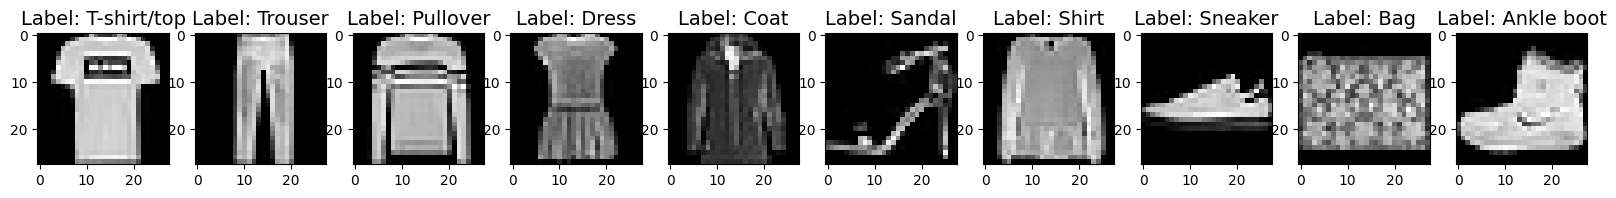

In [12]:
#ploting and labelled the dataset
fig,axes = plt.subplots(1, 10, figsize=(20,15))

# Create a mapping from class index to class name
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

#Display the image
for i in range(0, 10):
  axes[i].imshow(x_train[y_train == i][0], cmap=plt.get_cmap('gray'))
  axes[i].set_title("Label: {}".format(class_names[i]), fontsize=14)

In [13]:
# Count the occurrences of each digit in the training set
train_digit_count = np.bincount(y_train)

# Count the occurrences of each digit in the testing set
test_digit_count = np.bincount(y_test)

# Calculate the subtotal by adding the counts from the training and testing sets
subtotal_digit_count = train_digit_count + test_digit_count

# Calculate the total counts by summing the subtotal counts
total_digit_count = np.sum(subtotal_digit_count)

# Generate x-axis labels for each digit
digits = np.arange(10)

# Create a mapping from class index to class name
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Create a table
table = []
for class_name, digit, train_count, test_count, subtotal_count in zip(
    class_names, digits, train_digit_count, test_digit_count, subtotal_digit_count):
    table.append([class_name,digit, train_count, test_count, subtotal_count])

# Append a row for the subtotal
table.append(["Subtotal", "",np.sum(train_digit_count), np.sum(test_digit_count), np.sum(subtotal_digit_count)])

# Append a row for the total
table.append(["Total", "","", "", total_digit_count])

# Define the table headers
headers = ["Class Labels","Digit", "Training Data", "Testing Data", "Subtotal"]

# Print the table
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒════════════════╤═════════╤═════════════════╤════════════════╤════════════╕
│ Class Labels   │ Digit   │ Training Data   │ Testing Data   │   Subtotal │
╞════════════════╪═════════╪═════════════════╪════════════════╪════════════╡
│ T-shirt/top    │ 0       │ 6000            │ 1000           │       7000 │
├────────────────┼─────────┼─────────────────┼────────────────┼────────────┤
│ Trouser        │ 1       │ 6000            │ 1000           │       7000 │
├────────────────┼─────────┼─────────────────┼────────────────┼────────────┤
│ Pullover       │ 2       │ 6000            │ 1000           │       7000 │
├────────────────┼─────────┼─────────────────┼────────────────┼────────────┤
│ Dress          │ 3       │ 6000            │ 1000           │       7000 │
├────────────────┼─────────┼─────────────────┼────────────────┼────────────┤
│ Coat           │ 4       │ 6000            │ 1000           │       7000 │
├────────────────┼─────────┼─────────────────┼────────────────┼────────────┤

#Data Pre-processing

In [14]:
# Normalize Data
x_train = x_train / 255.0
x_test = x_test / 255.

# Reshape the input data to match the input shape of the model
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape)

(60000, 28, 28, 1)


In [15]:
#convert the lables into one-hot enconded vector
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#display the one-hot enconded vector
for i in range(10):
  print(y_train[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#Model Design(CNN without Hyperparameters)

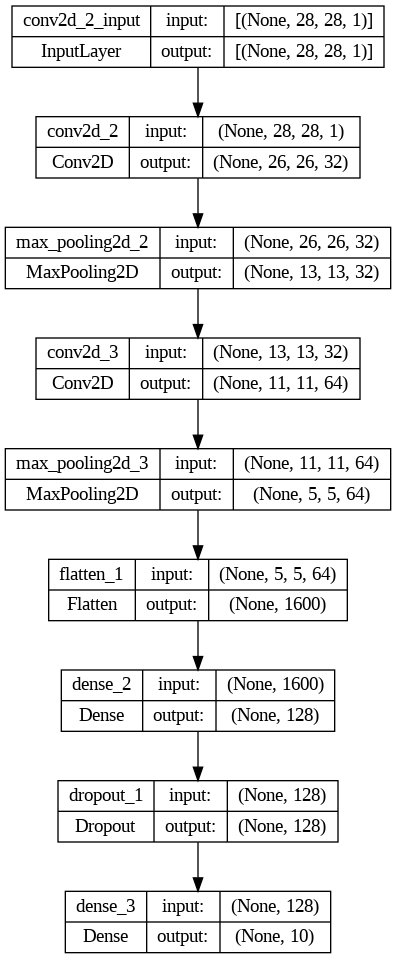

In [16]:
# Create the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generate a visualization of the model
plot_model(cnn_model, to_file='cnn_structure.png', show_shapes=True, show_layer_names=True)

#Model Design (CNN with Hyperparameter)

In [17]:
# Define model to build using Convolutional and Dense layers for image data
def define_model(units, activation, dropout, lr, conv_layers, dense_layers, filter_size, pool_size):
    # Define a model as Sequential to allow adding and connecting layers
    model = keras.Sequential()

    # Add Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters=filter_size, kernel_size=(3, 3), activation=activation, padding='same'))
        model.add(layers.MaxPooling2D(pool_size=pool_size))

    # Flatten the output from Convolutional layers
    model.add(layers.Flatten())

    # Add Dense layers
    for i in range(dense_layers):
        model.add(layers.Dense(units=units, activation=activation))
        # Check if the model will need dropout layer, if yes, add dropout layer
        if dropout:
            model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(10, activation="softmax"))

    # Compile the model using Adam optimizer, categorical cross-entropy as loss, and accuracy as evaluation metric
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Create hyperparameters for the CNN model to use tuner search on
def build_model(hp):
    # Define hyperparameters for the model
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh", "softmax", "sigmoid", "linear"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # Define CNN-specific hyperparameters
    conv_layers = hp.Int("conv_layers", min_value=1, max_value=4)
    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)
    filter_size = hp.Int("filter_size", min_value=16, max_value=128, step=16)
    pool_size = hp.Int("pool_size", min_value=2, max_value=4)

    # Call the model function to pass the parameters
    model = define_model(
        units=units,
        activation=activation,
        dropout=dropout,
        lr=lr,
        conv_layers=conv_layers,
        dense_layers=dense_layers,
        filter_size=filter_size,
        pool_size=pool_size,
    )
    return model


#Model training and validation (CNN with Hyperparameters)

In [31]:
#define tuner class search called Random Search to search randomly for perfect paramaeters on maximun trial of 3 since the dataset is big
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_document",
    project_name="AI Assignment",
)

#print the model summary
tuner.search_space_summary()

#seaech for the best hyper-parameters and validate the data to find best hyper-parameters
tuner.search(x_train, y_train, epochs=2, validation_data=(x_train, y_train))

Trial 3 Complete [00h 23m 46s]
val_accuracy: 0.9280999898910522

Best val_accuracy So Far: 0.9280999898910522
Total elapsed time: 00h 30m 29s


In [32]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)

# Build the model with the best hp.
model = build_model(best_hps[0])

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 163s 216ms/step - loss: 0.3917 - accuracy: 0.8584 - val_loss: 0.2969 - val_accuracy: 0.8911
Epoch 2/5
750/750 [==============================] - 161s 215ms/step - loss: 0.2517 - accuracy: 0.9071 - val_loss: 0.2529 - val_accuracy: 0.9104
Epoch 3/5
750/750 [==============================] - 160s 214ms/step - loss: 0.2011 - accuracy: 0.9251 - val_loss: 0.2426 - val_accuracy: 0.9122
Epoch 4/5
750/750 [==============================] - 160s 214ms/step - loss: 0.1643 - accuracy: 0.9386 - val_loss: 0.2410 - val_accuracy: 0.9157
Epoch 5/5
750/750 [==============================] - 158s 211ms/step - loss: 0.1365 - accuracy: 0.9485 - val_loss: 0.2736 - val_accuracy: 0.9018


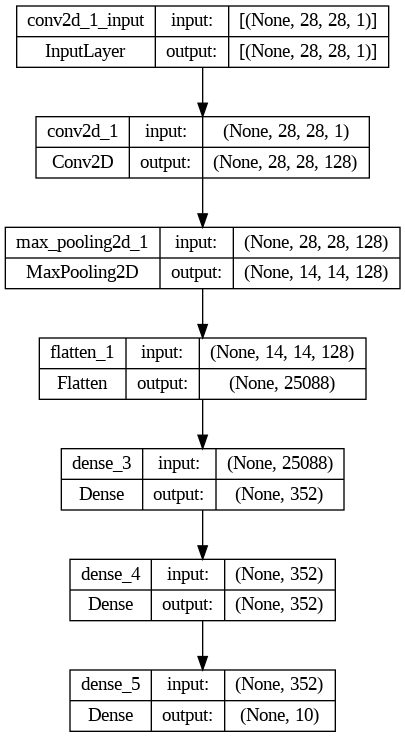

In [33]:
# Generate a visualization of the model
plot_model(model, to_file='cnn_structure(hyperparameters).png', show_shapes=True, show_layer_names=True)

In [34]:
# Evaluate the model (CNN with Hyperparamaters) on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

313/313 - 9s - loss: 0.2826 - accuracy: 0.9023 - 9s/epoch - 29ms/step
Test accuracy: 90.23%


#Model training and validation(CNN without Hyperparameters)

In [19]:
# Train the model (CNN without hyperparameters)
cnn_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model(CNN without hyperparameters) on the test data
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Epoch 1/5
750/750 [==============================] - 57s 74ms/step - loss: 0.6309 - accuracy: 0.7716 - val_loss: 0.4085 - val_accuracy: 0.8527
Epoch 2/5
750/750 [==============================] - 53s 71ms/step - loss: 0.4167 - accuracy: 0.8508 - val_loss: 0.3449 - val_accuracy: 0.8723
Epoch 3/5
750/750 [==============================] - 53s 70ms/step - loss: 0.3594 - accuracy: 0.8703 - val_loss: 0.3104 - val_accuracy: 0.8857
Epoch 4/5
750/750 [==============================] - 53s 71ms/step - loss: 0.3261 - accuracy: 0.8818 - val_loss: 0.2896 - val_accuracy: 0.8933
Epoch 5/5
750/750 [==============================] - 50s 67ms/step - loss: 0.3063 - accuracy: 0.8889 - val_loss: 0.2673 - val_accuracy: 0.9013
313/313 - 3s - loss: 0.2920 - accuracy: 0.8943 - 3s/epoch - 11ms/step
Test accuracy: 89.43%


#Model evaluation and testing(CNN without Hyperparameters)

313/313 [==============================] - 4s 11ms/step


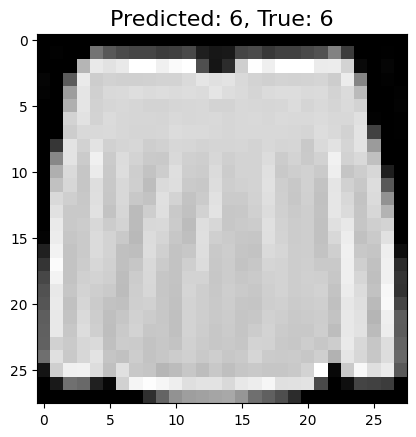

In [20]:
# check if the model predict the exert value by outputing the predicted and true value
y_predict = cnn_model.predict(x_test)
y_pred_class = np.argmax(y_predict, axis=1)

#randomly find the index of image number to predict
random_index = np.random.choice(len(x_test))

#find the value to test using random index
x_samples = x_test[random_index]

#Find the index of the true value
y_true_value = np.argmax(y_test, axis=1)

#find the true value
y_sampleTrue = y_true_value[random_index]

#predict the class of the value
y_sample_predClass = y_pred_class[random_index]

#display the image
plt.title("Predicted: {}, True: {}".format(y_sample_predClass, y_sampleTrue), fontsize=16)
plt.imshow(x_samples.reshape(28, 28), cmap='gray')

In [30]:
# Calculate accuracy
accuracy = accuracy_score(y_true_value, y_pred_class)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true_value, y_pred_class,average='macro')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true_value, y_pred_class,average='macro')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true_value, y_pred_class,average='macro')
print("F1 Score:", f1)


Accuracy: 0.8943
Precision: 0.8937506293831765
Recall: 0.8943
F1 Score: 0.8934079107006692


#Model evaluation and testing(CNN with Hyperparameters)

313/313 [==============================] - 10s 31ms/step


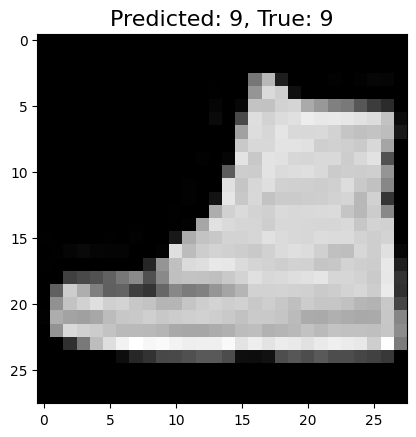

In [35]:
# check if the model predict the exert value by outputing the predicted and true value
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

#randomly find the index of image number to predict
random_idx = np.random.choice(len(x_test))

#find the value to test using random index
x_sample = x_test[random_idx]

#Find the index of the true value
y_true = np.argmax(y_test, axis=1)

#find the true value
y_sample_true = y_true[random_idx]

#predict the class of the value
y_sample_pred_class = y_pred_classes[random_idx]

#display the image
plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred_classes,average='macro')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred_classes,average='macro')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes,average='macro')
print("F1 Score:", f1)

Accuracy: 0.9023
Precision: 0.9100460098282385
Recall: 0.9023
F1 Score: 0.9023788250707792


#Confusion Matrix (CNN without Hyperparameters)

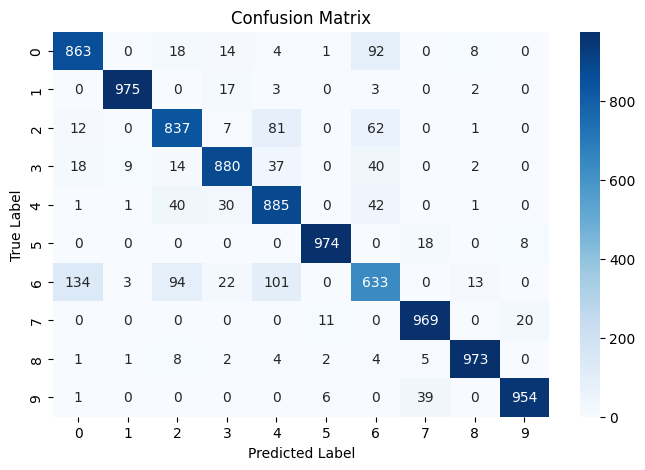

In [38]:
#display all the predicted imagies class and the error that model did during testing
confusion_mtx = confusion_matrix(y_true_value, y_pred_class)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

#Confusion Matrix(CNN with Hyperparameters)

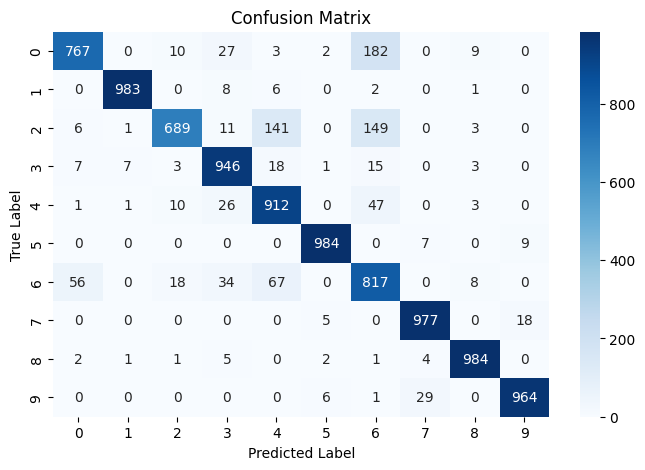

In [39]:
#display all the predicted imagies class and the error that model did during testing
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');